In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import  statsmodels.tsa.api as tsa # new import
from sklearn import set_config
#set_config(transform_output="pandas")
plt.rcParams["figure.figsize"] = (12, 4)
sns.set_context("talk", font_scale=0.9)
# set random seed
SEED = 321
np.random.seed(SEED)

In [2]:
# Calculating a simulated white noise time series (one value)
c = 49
noise_t = np.random.normal()
# Add the random value to the mean to get the duration of the lap for one day
y_t= c + noise_t
y_t

49.17251946894025

In [3]:
# Calculating a simulated white noise time series for 120 days
c = 49
n_lags = 120
y = []
for t in range(n_lags):
    
    noise_t = np.random.normal(size=1)
    y_t = c + noise_t[0] # slicing 0 to get value instead of arrays
    y.append(y_t)

In [4]:
# Convet list to a Pandas Series
ts_white_noise = pd.Series(y, name='Simulated White Noise')     
ts_white_noise

0      50.635483
1      49.037336
2      48.115850
3      47.856808
4      48.378634
         ...    
115    50.081623
116    49.227369
117    50.421600
118    48.683405
119    47.880499
Name: Simulated White Noise, Length: 120, dtype: float64

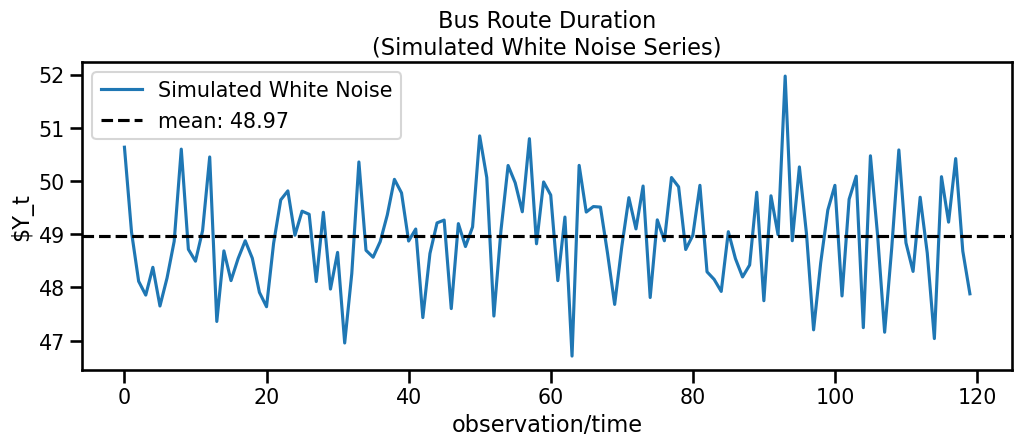

In [6]:
# Plotting the white noise series with annotated mean
ax = ts_white_noise.plot()
ax.set(title='Bus Route Duration\n(Simulated White Noise Series)',
       ylabel='$Y_t', xlabel='observation/time');
ax.axhline(ts_white_noise.mean(),  color='k', ls='--',
           label=f'mean: {ts_white_noise.mean():.2f}');
ax.legend();

In [7]:
# Running the adfuller test to demonstrate return
tsa.adfuller(ts_white_noise)

(-11.133859534698885,
 3.2317307055656125e-20,
 0,
 119,
 {'1%': -3.4865346059036564,
  '5%': -2.8861509858476264,
  '10%': -2.579896092790057},
 295.21163114049114)

In [8]:
# Saving each output separately
(test_stat, pval, nlags, nobs, crit_vals_d, icbest) = tsa.adfuller(ts_white_noise)

In [9]:
# Saving the most important results as a dictionary
adfuller_results = {'Test Statistic': test_stat,
                    "# of Lags Used":nlags, 
                   '# of Observations':nobs,
                    'p-value': round(pval,6)}

In [10]:
# Adding interpretation of p-value to dictionary
alpha =.05
adfuller_results['sig/stationary?'] = pval < alpha
adfuller_results

{'Test Statistic': -11.133859534698885,
 '# of Lags Used': 0,
 '# of Observations': 119,
 'p-value': 0.0,
 'sig/stationary?': True}

In [11]:
# Convert dictionary of results to a dataframe
adfuller_df = pd.DataFrame(adfuller_results, index=['AD Fuller Test'])
adfuller_df

,Test Statistic,# of Lags Used,# of Observations,p-value,sig/stationary?
AD Fuller Test,-11.13386,0,119,0.0,True


In [12]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [13]:
# Testing the function
adfuller_results = get_adfuller_results(ts_white_noise, label='White Noise')
adfuller_results

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
White Noise,-11.13386,0,119,0.0,0.05,True


# Autocorrelation

In [14]:
# Shift the data one step 
ts_lag1 = ts_white_noise.shift(1)
ts_lag1 = ts_lag1.rename('Lag 1')
ts_lag1.head()

0          NaN
1    50.635483
2    49.037336
3    48.115850
4    47.856808
Name: Lag 1, dtype: float64

In [15]:
# Combine original ts + with lag 1
ts_lagged = pd.concat([ts_white_noise,ts_lag1], axis=1)
ts_lagged.head()

,Simulated White Noise,Lag 1
0,50.635483,NaN
1,49.037336,50.635483
2,48.115850,49.037336
3,47.856808,48.115850
4,48.378634,47.856808


In [16]:
# Checking for correlation
ts_lagged.corr()

,Simulated White Noise,Lag 1
Simulated White Noise,1.000000,-0.021783
Lag 1,-0.021783,1.000000


In [17]:
# Generate 20 time-shifted columns
ts_lagged = pd.DataFrame()
total_shifts = 20
for t in range(0,total_shifts+1):    
    ts_lagged[f"Lag {t}"] =  ts_white_noise.shift(t)
ts_lagged.head()

,Lag 0,Lag 1,Lag 2,Lag 3,Lag 4,Lag 5,Lag 6,Lag 7,Lag 8,Lag 9,...,Lag 11,Lag 12,Lag 13,Lag 14,Lag 15,Lag 16,Lag 17,Lag 18,Lag 19,Lag 20
0,50.635483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,49.037336,50.635483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,48.115850,49.037336,50.635483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,47.856808,48.115850,49.037336,50.635483,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,48.378634,47.856808,48.115850,49.037336,50.635483,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# Calculate correlations for all values
corr = ts_lagged.corr()
corr.head()

,Lag 0,Lag 1,Lag 2,Lag 3,Lag 4,Lag 5,Lag 6,Lag 7,Lag 8,Lag 9,...,Lag 11,Lag 12,Lag 13,Lag 14,Lag 15,Lag 16,Lag 17,Lag 18,Lag 19,Lag 20
Lag 0,1.000000,-0.021783,-0.064080,-0.018734,-0.014180,-0.118503,0.018079,0.064780,-0.173773,-0.128825,...,0.058375,0.038630,-0.037089,0.075861,0.021654,0.175557,0.166579,-0.028704,-0.282454,-0.125067
Lag 1,-0.021783,1.000000,-0.024832,-0.050657,-0.016234,-0.002859,-0.141524,0.014664,0.073168,-0.182525,...,0.142978,0.056308,0.019034,-0.037182,0.094835,0.001457,0.191472,0.176576,-0.043111,-0.274006
Lag 2,-0.064080,-0.024832,1.000000,-0.021312,-0.050016,-0.013321,-0.008398,-0.142619,0.016912,0.071255,...,-0.127894,0.142397,0.051440,0.019082,-0.032922,0.090528,0.005322,0.194548,0.173809,-0.039859
Lag 3,-0.018734,-0.050657,-0.021312,1.000000,-0.025063,-0.066142,0.013100,-0.003901,-0.154446,0.026492,...,-0.210015,-0.126081,0.172880,0.051795,-0.002686,-0.007229,0.074885,-0.005278,0.215711,0.161757
Lag 4,-0.014180,-0.016234,-0.050016,-0.025063,1.000000,-0.028093,-0.062291,0.013955,-0.005708,-0.153189,...,0.071136,-0.209615,-0.123666,0.172903,0.048696,0.001656,-0.010319,0.073314,-0.002383,0.214486


In [19]:
# Slice out the original ts (lag 0)
auto_corr = corr['Lag 0']
auto_corr

Lag 0     1.000000
Lag 1    -0.021783
Lag 2    -0.064080
Lag 3    -0.018734
Lag 4    -0.014180
Lag 5    -0.118503
Lag 6     0.018079
Lag 7     0.064780
Lag 8    -0.173773
Lag 9    -0.128825
Lag 10    0.122801
Lag 11    0.058375
Lag 12    0.038630
Lag 13   -0.037089
Lag 14    0.075861
Lag 15    0.021654
Lag 16    0.175557
Lag 17    0.166579
Lag 18   -0.028704
Lag 19   -0.282454
Lag 20   -0.125067
Name: Lag 0, dtype: float64

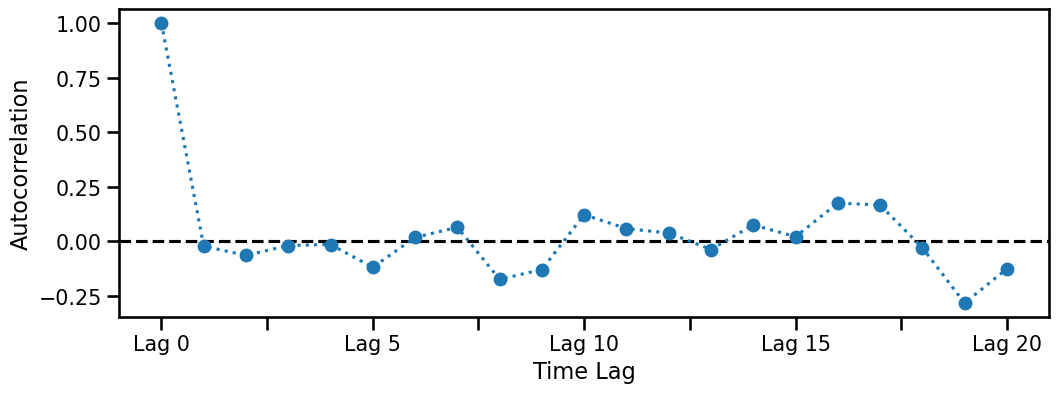

In [20]:
# Plot the calculated correlations
ax = auto_corr.plot(style='o:')
ax.axhline(0, color='k', ls='--', zorder=-1);
ax.set(ylabel='Autocorrelation', xlabel='Time Lag');

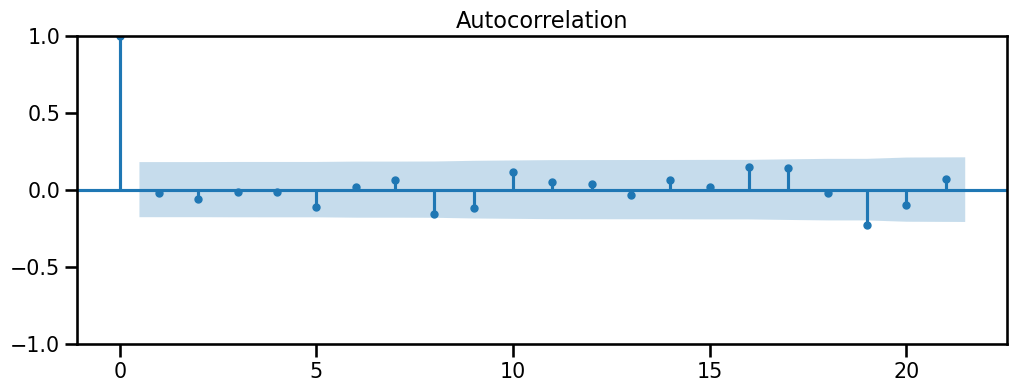

In [21]:
# Plotting autocorrelation with built in function
fig = tsa.graphics.plot_acf(ts_white_noise);

In [22]:
# Calculating a simulated random walk 
first_t = 150
y_walk = [first_t]
n_lags=120
for t in range(1,n_lags):
    # get the previous time lag's value
    y_prev_t = y_walk[t-1]
    
    # Get new noise
    noise_t = np.random.normal(size=1)
    
    # Add noise on to previous value
    y_t = y_prev_t + noise_t[0] # slicing 0 to get value instead of arrays
    y_walk.append(y_t)
    
ts_rand_walk = pd.Series(y_walk, name='Simulated Random Walk')    
ts_rand_walk

0      150.000000
1      148.598865
2      147.131094
3      148.014590
4      147.161973
          ...    
115    153.871576
116    152.788941
117    153.142111
118    155.103555
119    155.816590
Name: Simulated Random Walk, Length: 120, dtype: float64

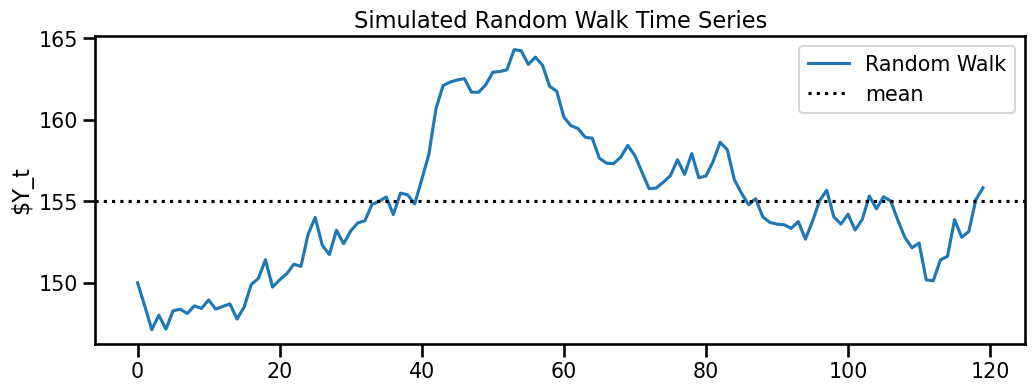

In [23]:
# Visualize the random walk time series
ax = ts_rand_walk.plot(label='Random Walk')
ax.set(ylabel='$Y_t', title='Simulated Random Walk Time Series');
ax.axhline(ts_rand_walk.mean(), color='black', ls=':', label='mean');
ax.legend();

In [24]:
# Test random walk forstationarity
get_adfuller_results(ts_rand_walk)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-1.442588,0,119,0.561697,0.05,False


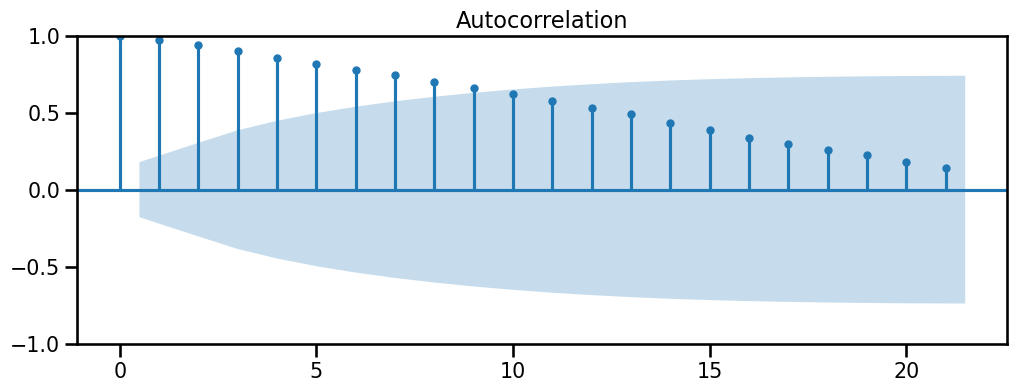

In [25]:
# Check for autocorrelation
tsa.graphics.plot_acf(ts_rand_walk);

In [26]:
# Orignal random walk
ts_rand_walk.head()

0    150.000000
1    148.598865
2    147.131094
3    148.014590
4    147.161973
Name: Simulated Random Walk, dtype: float64

In [27]:
# Differenced random walk
ts_rand_walk.diff().head()

0         NaN
1   -1.401135
2   -1.467771
3    0.883495
4   -0.852617
Name: Simulated Random Walk, dtype: float64

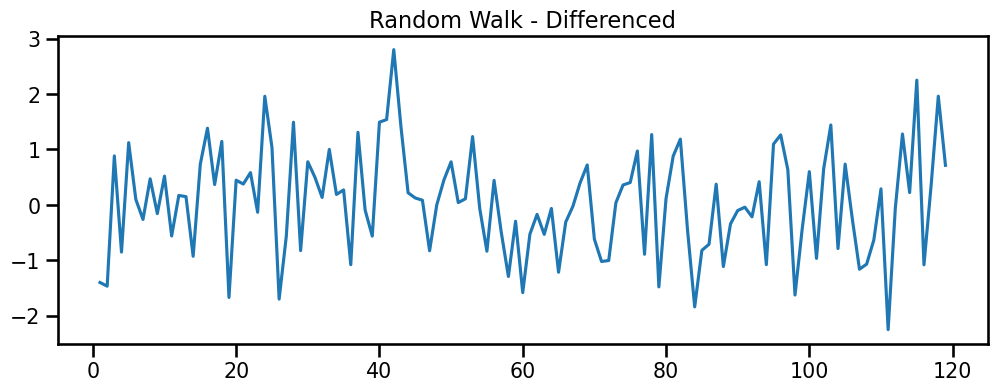

In [28]:
# Plot the differenced random walk
ts_rand_walk_diff = ts_rand_walk.diff().dropna()
ts_rand_walk_diff.plot(title='Random Walk - Differenced');

In [29]:
# Test differenced random walk for stationarity
get_adfuller_results(ts_rand_walk_diff)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-10.109419,0,118,0.0,0.05,True


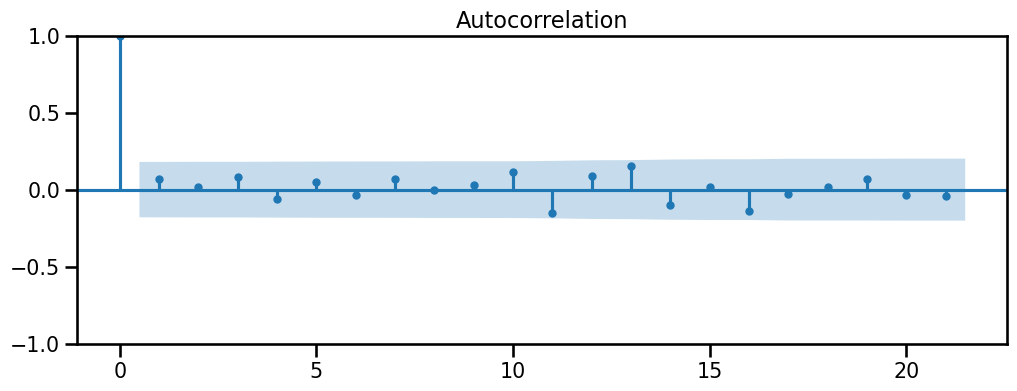

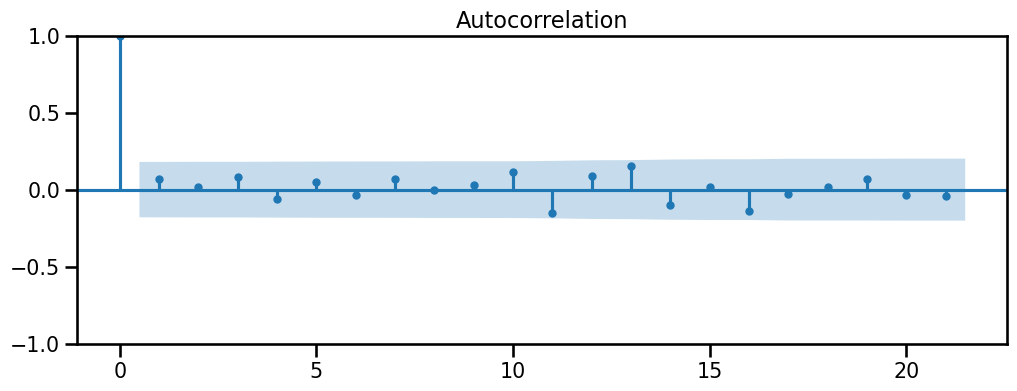

In [30]:
# Check differenced random walk for autocorrelation
tsa.graphics.plot_acf(ts_rand_walk_diff)

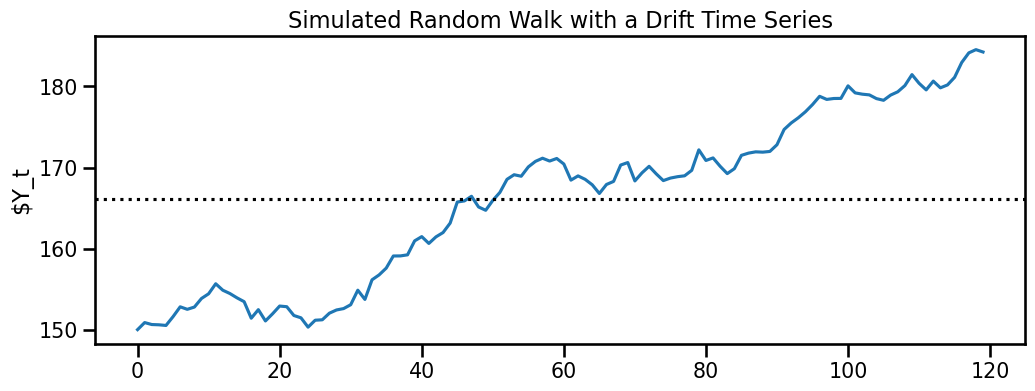

In [31]:
# Creating simulated random walk with a drift
first_t = 150
c = .3
y_walk_drift = [first_t]
for t in range(1,n_lags):
    # get the previous time lag's value
    y_prev_t = y_walk_drift[t-1]
    
    # Get new noise
    noise_t = np.random.normal(size=1)
    # Add noise on to previous value
    y_t = c + y_prev_t + noise_t[0]# slicing 0 to get value instead of arrays
    y_walk_drift.append(y_t)
    
ts_rand_walk_drift = pd.Series(y_walk_drift, name = "Simulated Random walk (+dift)")    
ax = ts_rand_walk_drift.plot()
ax.set(ylabel='$Y_t', title='Simulated Random Walk with a Drift Time Series');
ax.axhline(ts_rand_walk_drift.mean(), color='black', ls=':');

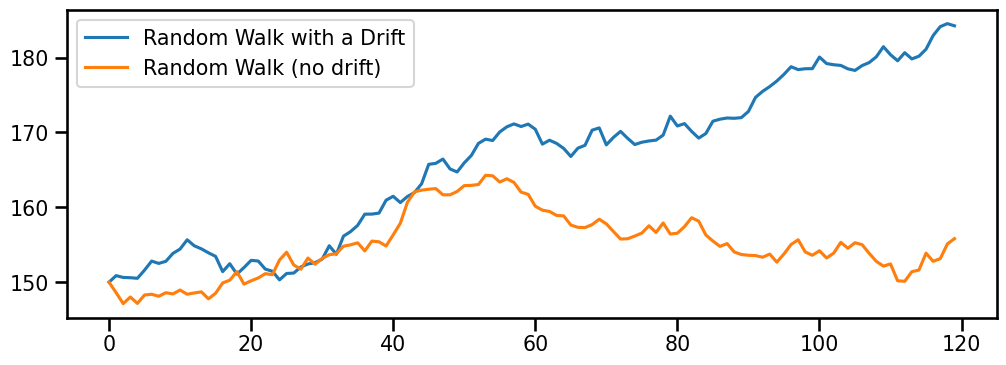

In [32]:
# compare random walk with a drift vs without
ax = ts_rand_walk_drift.plot(label='Random Walk with a Drift')
ts_rand_walk.plot(ax=ax, label='Random Walk (no drift)')
ax.legend();

In [33]:
# Test random walk with a drift for stationarity
get_adfuller_results(ts_rand_walk_drift)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-0.189886,0,119,0.939716,0.05,False


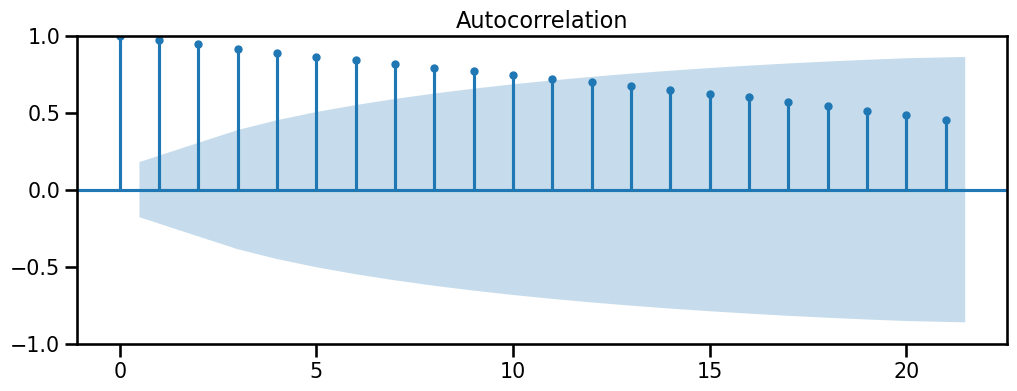

In [34]:
# Test random walk a with a drift for autocorrelation
tsa.graphics.plot_acf(ts_rand_walk_drift);

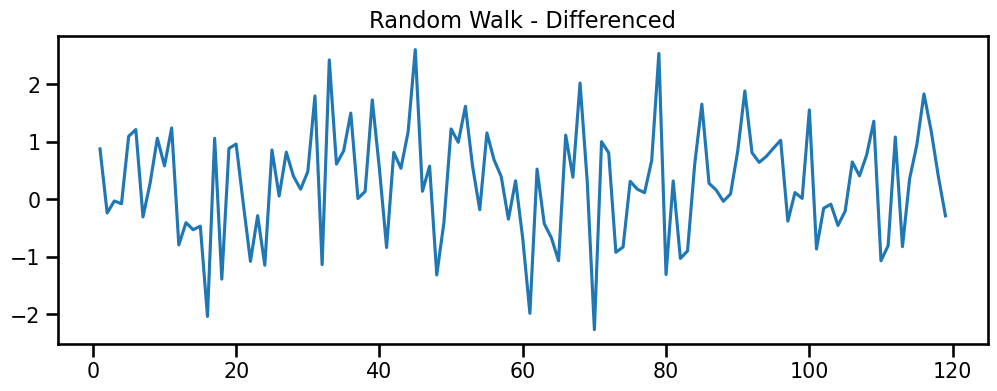

In [35]:
# Difference the random walk with a drift
ts_rand_walk_drift_diff = ts_rand_walk_drift.diff().dropna()
# Visualize the differenced random walk with a drift
ts_rand_walk_drift_diff.plot(title='Random Walk - Differenced');

In [36]:
# Confirm that a differenced random walk with drift is stationary
get_adfuller_results(ts_rand_walk_drift_diff)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-10.45481,0,118,0.0,0.05,True


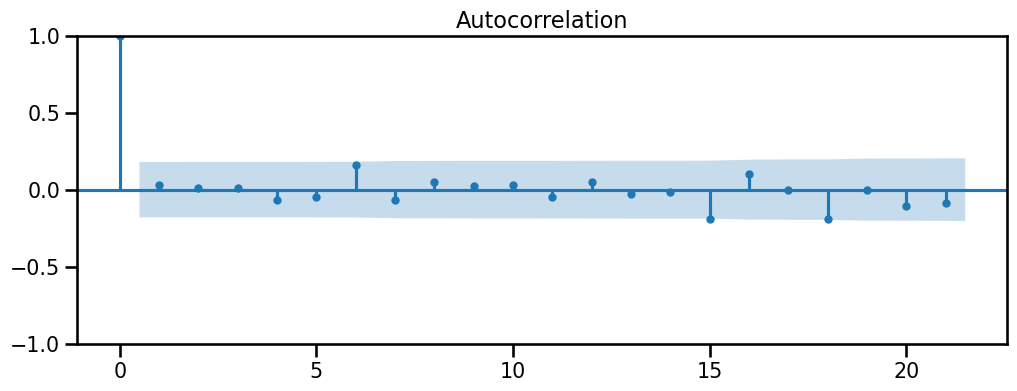

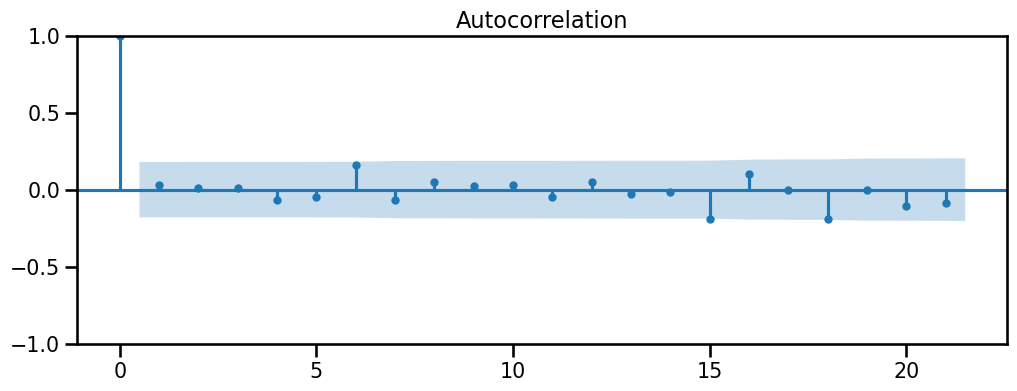

In [37]:
# Check the differenced random walk with drift for autocorrelation
tsa.graphics.plot_acf(ts_rand_walk_drift_diff)